In [ ]:
%pip install ngboost
%pip install "xgboost>=2.0.0"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=d8e0bda62fa9ea14a150f0b565b06e83a6deca33f840f46ea81beb0f54d0b6d4
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [1]:
try:
    from ngboost import NGBRegressor
    from ngboost.distns import Normal
    HAVE_NGBOOST = True
except Exception:
    HAVE_NGBOOST = False


In [2]:
import os
import json
import ast
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# Seleciona variaveis

In [ ]:
# =========================
# Config (seus valores)
# =========================
CSV_PATH    = "dados_2h_aggregado_final.csv"   # <-- ajuste o caminho
TARGET      = "P_CONFLTTO_QQ_GLOBAL_SIO2"
TIME_COL    = "Data"
CORR_THRESH = 0.8
TEST_SIZE   = 0.2
VAL_SIZE    = 0.2      # fração do treino reservada p/ early stopping
RANDOM_SEED = 42

# =========================
# Utils
# =========================
def read_csv_safely(path):
    last_err = None
    for enc in ("utf-8", "latin1", "cp1252"):
        try:
            return pd.read_csv(path, sep=None, engine="python", encoding=enc)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Falha ao abrir {path}. Último erro: {last_err}")

def greedy_corr_filter(X_num: pd.DataFrame, thresh: float = 0.8):
    """
    Remove colunas altamente correlacionadas (|corr| > thresh).
    Critério: remove a variável com maior média de |corr| com as demais.
    """
    corr = X_num.corr().abs()
    ativos = set(corr.columns)
    removidos = set()
    while True:
        cols = sorted(ativos)
        if len(cols) <= 1:
            break
        sub = corr.loc[cols, cols].copy()
        np.fill_diagonal(sub.values, 0.0)
        max_val = sub.values.max()
        if max_val <= thresh:
            break
        i, j = np.unravel_index(np.argmax(sub.values), sub.shape)
        vi, vj = cols[i], cols[j]
        to_remove = vi if sub[vi].mean() >= sub[vj].mean() else vj
        ativos.remove(to_remove)
        removidos.add(to_remove)
    return sorted(ativos), sorted(removidos)

def fit_xgb_with_es(X_tr, y_tr, X_val, y_val, params=None):
    """Treina XGBRegressor com early stopping (compatível com diferentes versões)."""
    if params is None:
        params = dict(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.06,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_SEED,
            n_jobs=-1,
            tree_method="hist",
        )
    model = XGBRegressor(**params)
   
    try:
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False,
            early_stopping_rounds=50
        )
    except TypeError:
        try:
            from xgboost.callback import EarlyStopping
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False,
                callbacks=[EarlyStopping(rounds=50, save_best=True)]
            )
        except Exception:
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    return model

def rank_features_by_gain(model, feature_names):
    """
    Extrai importância por 'gain'. Se não disponível, cai em feature_importances_.
    """
    booster = model.get_booster()
    try:
        gain = booster.get_score(importance_type="gain")  # {'f0': gain0, ...}
        scores = [gain.get(f"f{j}", 0.0) for j in range(len(feature_names))]
    except Exception:
        scores = list(getattr(model, "feature_importances_", np.zeros(len(feature_names))))
    df_imp = pd.DataFrame({"feature": feature_names, "gain": scores})
    df_imp = df_imp.sort_values("gain", ascending=False).reset_index(drop=True)
    return df_imp

# =========================
# 1) Ler dados
# =========================
df = read_csv_safely(CSV_PATH)
if TARGET not in df.columns:
    raise ValueError(f"Coluna alvo '{TARGET}' não encontrada no CSV.")

y = pd.to_numeric(df[TARGET], errors="coerce")
mask_y = y.notna()
df = df.loc[mask_y].reset_index(drop=True)
y  = y.loc[mask_y].reset_index(drop=True)

# =========================
# 2) Seleção inicial de features (exclui prefixo 'P' e não numéricas)
# =========================
feature_candidates = [c for c in df.columns if not c.startswith("P") and c != TARGET]
X = df[feature_candidates].dropna(axis=1, how="all").select_dtypes(include=[np.number])

print(f"Features candidatas iniciais (sem prefixo 'P'): {X.shape[1]}")

# =========================
# 3) Remover colinearidade |corr| > CORR_THRESH
# =========================
kept_cols, removed_cols = greedy_corr_filter(X, CORR_THRESH)
X = X[kept_cols].copy()
print(f"Removidas por |corr| > {CORR_THRESH}: {len(removed_cols)}")
print(f"Features finais após filtro: {X.shape[1]}")

# (opcional) salvar lista completa das features finais (pós-filtro)
pd.Series(kept_cols).to_csv("final_features_after_corr_filter.txt",
                            index=False, header=False, encoding="utf-8")

# =========================
# 4) Split temporal (se possível) → depois split do treino p/ validação
# =========================
time_sorted = False
if TIME_COL in df.columns:
    order = pd.to_datetime(df[TIME_COL], errors="coerce")
    if order.notna().mean() > 0.5:
        idx = order.argsort(kind="mergesort")
        X = X.iloc[idx].reset_index(drop=True)
        y = y.iloc[idx].reset_index(drop=True)
        time_sorted = True

# Holdout teste
if time_sorted:
    cut = int((1 - TEST_SIZE) * len(X))
    X_train, X_test = X.iloc[:cut], X.iloc[cut:]
    y_train, y_test = y.iloc[:cut], y.iloc[cut:]
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
    )

# Split treino -> (treino interno + validação) para early stopping
if time_sorted:
    cut_in = int((1 - VAL_SIZE) * len(X_train))
    X_tr_in, X_val_in = X_train.iloc[:cut_in], X_train.iloc[cut_in:]
    y_tr_in, y_val_in = y_train.iloc[:cut_in], y_train.iloc[cut_in:]
else:
    X_tr_in, X_val_in, y_tr_in, y_val_in = train_test_split(
        X_train, y_train, test_size=VAL_SIZE, random_state=RANDOM_SEED
    )

# =========================
# 5) Importância por 'gain' com TODAS as features do treino interno
# =========================
imp_rank = SimpleImputer(strategy="median")
X_tr_in_imp_full = imp_rank.fit_transform(X_tr_in).astype(np.float32)
X_val_in_imp_full = imp_rank.transform(X_val_in).astype(np.float32)

base_model = fit_xgb_with_es(X_tr_in_imp_full, y_tr_in.values, X_val_in_imp_full, y_val_in.values)
ranking_df = rank_features_by_gain(base_model, X_tr_in.columns.tolist())

# =========================
# 6) Listas pedidas + impressões/arquivos auxiliares
# =========================

# 6.1) Lista das features finais após o filtro de correlação
features1 = list(kept_cols)
print("\n==== FEATURES FINAIS APÓS O FILTRO DE CORRELAÇÃO ====")
print(f"Total: {len(features1)}")
for f in features1:
    print(" -", f)

# 6.2) Top-N por |correlação| com o alvo (usa X já filtrado e y alinhado)
N_TOP = min(10, len(features1))
corr_target = pd.concat([X, y.rename("_y")], axis=1).corr()["_y"] \
                 .drop("_y").abs().sort_values(ascending=False)
top_corr = corr_target.head(N_TOP)
features2 = top_corr.index.tolist()

print(f"\n==== TOP-{N_TOP} POR |CORRELAÇÃO| COM O ALVO ====")
print(top_corr)

# (opcional) salvar correlações
top_corr.to_csv("top_corr_with_target.csv", header=["abs_pearson"], encoding="utf-8")

# 6.3) Top-N por importância
ranking_df.to_csv("feature_importance_gain_full.csv", index=False, encoding="utf-8")
top_gain = ranking_df.head(N_TOP).copy()
features3 = top_gain["feature"].tolist()

print(f"\n==== TOP-{N_TOP} POR IMPORTÂNCIA (XGBoost 'gain') ====")
print(top_gain)

top_gain.to_csv("top_importance_gain.csv", index=False, encoding="utf-8")

# 6.4) Visualização final das três listas pedidas
print("\nfeatures1 =", features1)  # finais pós-filtro
print("features2 =", features2)    # top-N correlação
print("features3 =", features3)    # top-N importância


Features candidatas iniciais (sem prefixo 'P'): 42
Removidas por |corr| > 0.8: 6
Features finais após filtro: 36

==== FEATURES FINAIS APÓS O FILTRO DE CORRELAÇÃO ====
Total: 36
 - TO_AI6401_01
 - TO_AI6402_01
 - TO_BO6311_EST1
 - TO_DI6311_01
 - TO_FI6311_01
 - TO_FI8271_01
 - TO_FY6104_01
 - TO_LI6401_01
 - TO_LI6401_02
 - TO_LI6402_01
 - TO_LI6411_01
 - TO_LI6411_02
 - TO_LI6412_01
 - TO_LI6412_02
 - TO_LI6431_01
 - TO_LI6432_01
 - TO_MF6401_M1_EST1
 - TO_MF6402_M1_EST1
 - TO_MF6411_M1_EST1
 - TO_MF6412_M1_EST1
 - TO_MF6421_M1_EST1
 - TO_PHY4804_02
 - TO_PHY4814_02
 - TO_SIMF640101
 - TO_SIMF640102
 - TO_SIMF640201
 - TO_SIMF640202
 - TO_SIMF641101
 - TO_SIMF641102
 - TO_SIMF641201
 - TO_SIMF641202
 - TO_SIMF6421
 - TO_SIMF6422
 - TO_SIMF6431
 - TO_SIMF6432
 - TO_WI4804_01

==== TOP-10 POR |CORRELAÇÃO| COM O ALVO ====
TO_WI4804_01         0.126832
TO_PHY4814_02        0.117796
TO_PHY4804_02        0.076092
TO_SIMF641201        0.071923
TO_LI6412_01         0.060203
TO_SIMF640202    

In [ ]:
#
#  - MIM (Mutual Information Maximization)
#  - Backward Selection (wrapper por validação)
#  - GroupFS (seleção por grupos de sensores, forward wrapper)
# Compatível com xgboost>=2.1 (usa early_stopping_rounds no __init__)
# ---------------------------------------------------------------------

import os
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression

import xgboost as xgb
from xgboost import XGBRegressor

# =========================
# Config (ajuste conforme precisar)
# =========================
CSV_PATH     = "dados_2h_aggregado_final.csv"
TARGET       = "P_CONFLTTO_QQ_GLOBAL_SIO2"
TIME_COL     = "Data"
CORR_THRESH  = 0.80
TEST_SIZE    = 0.20
VAL_SIZE     = 0.10
RANDOM_SEED  = 42
ES_ROUNDS    = 200
OUTPUT_DIR   = "outputs_feature_selection"

# MIM
K_MIM        = 10     # quantidade de features a pegar no MIM
MIM_N_NEIGH  = 3

# Backward Selection
BACK_MIN_FEATS        = 6      # mínimo de features ao parar
BACK_MAX_STEPS        = 50     # segurança
BACK_CANDIDATES_PER_STEP = 5   # avalia remover dentre as 5 piores por importância
BACK_MIN_IMPROVEMENT  = 0.0    # exige melhora (<= atual - 0)

# GroupFS
GROUPFS_MAX_GROUPS    = None   # None = até não melhorar mais
GROUPFS_MIN_IMPROV    = 0.0

# =========================
# Utils
# =========================
def read_csv_safely(path):
    last_err = None
    for enc in ("utf-8", "latin1", "cp1252"):
        try:
            return pd.read_csv(path, sep=None, engine="python", encoding=enc)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Falha ao abrir {path}. Último erro: {last_err}")


def greedy_corr_filter(X_num: pd.DataFrame, thresh: float = 0.8):
    """
    Remove colunas altamente correlacionadas (|corr| > thresh).
    Critério: remove a variável com maior média de |corr| com as demais.
    """
    corr = X_num.corr().abs()
    ativos = set(corr.columns)
    removidos = set()
    while True:
        cols = sorted(ativos)
        if len(cols) <= 1:
            break
        sub = corr.loc[cols, cols].copy()
        np.fill_diagonal(sub.values, 0.0)
        if sub.values.size == 0:
            break
        max_val = sub.values.max()
        if max_val <= thresh:
            break
        i, j = np.unravel_index(np.argmax(sub.values), sub.shape)
        vi, vj = cols[i], cols[j]
        to_remove = vi if sub[vi].mean() >= sub[vj].mean() else vj
        ativos.remove(to_remove)
        removidos.add(to_remove)
    return sorted(ativos), sorted(removidos)


def make_xgb(**overrides):
    params = dict(
        n_estimators=10000,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_SEED,
        n_jobs=-1,
        tree_method="hist",
        objective="reg:squarederror",
        eval_metric="rmse",
        early_stopping_rounds=ES_ROUNDS,
    )
    params.update(overrides)
    return XGBRegressor(**params)


def fit_es_and_mae(X_tr, y_tr, X_val, y_val, features):
    """Treina XGB com ES e retorna (modelo, mae_val)."""
    model = make_xgb()
    model.fit(X_tr[features], y_tr, eval_set=[(X_val[features], y_val)], verbose=False)
    pred_val = model.predict(X_val[features])
    mae = mean_absolute_error(y_val, pred_val)
    return model, mae


def rank_features_by_gain(model, feature_names):
    """Extrai importância por 'gain'. Se não disponível, cai em feature_importances_."""
    booster = model.get_booster()
    try:
        gain = booster.get_score(importance_type="gain")  # {'f0': gain0, ...}
        scores = [gain.get(f"f{j}", 0.0) for j in range(len(feature_names))]
    except Exception:
        scores = list(getattr(model, "feature_importances_", np.zeros(len(feature_names))))
    df_imp = pd.DataFrame({"feature": feature_names, "gain": scores})
    df_imp = df_imp.sort_values("gain", ascending=False).reset_index(drop=True)
    return df_imp


def select_MIM(X_tr: pd.DataFrame, y_tr: pd.Series, k: int, n_neighbors: int = 3):
    Xn = X_tr.values
    yn = y_tr.values
    scores = mutual_info_regression(Xn, yn, n_neighbors=n_neighbors, random_state=RANDOM_SEED)
    df = pd.DataFrame({"feature": X_tr.columns, "mi": scores}).sort_values("mi", ascending=False)
    chosen = df.head(k)["feature"].tolist()
    return chosen, df.reset_index(drop=True)


def backward_selection(X_tr: pd.DataFrame, y_tr: pd.Series,
                       X_val: pd.DataFrame, y_val: pd.Series,
                       start_features: list,
                       min_features: int = BACK_MIN_FEATS,
                       candidates_per_step: int = BACK_CANDIDATES_PER_STEP,
                       max_steps: int = BACK_MAX_STEPS,
                       min_improvement: float = BACK_MIN_IMPROVEMENT):
    """Greedy backward (remove 1 por step escolhendo entre as piores importâncias).
    Retorna (selected_features, histórico)"""
    feats = list(start_features)
    history = []

    # baseline
    base_model, base_mae = fit_es_and_mae(X_tr, y_tr, X_val, y_val, feats)
    history.append({"step": 0, "features": len(feats), "removed": None, "val_mae": base_mae})

    step = 1
    cur_mae = base_mae

    while len(feats) > min_features and step <= max_steps:
        # importância no conjunto atual
        imp_df = rank_features_by_gain(base_model, feats)
        candidates = list(imp_df.tail(min(candidates_per_step, len(feats)-min_features))['feature'])

        best_remove = None
        best_mae = cur_mae

        for f in candidates:
            tmp_feats = [x for x in feats if x != f]
            _, mae = fit_es_and_mae(X_tr, y_tr, X_val, y_val, tmp_feats)
            if mae <= best_mae - min_improvement:
                best_mae = mae
                best_remove = f

        if best_remove is None:
            break

        feats.remove(best_remove)
        cur_mae = best_mae
        base_model, _ = fit_es_and_mae(X_tr, y_tr, X_val, y_val, feats)
        history.append({"step": step, "features": len(feats), "removed": best_remove, "val_mae": cur_mae})
        step += 1

    return feats, pd.DataFrame(history)


def group_key(name: str) -> str:
    """Define o grupo pela família após 'TO_': ex.: TO_AI..., TO_SIMF..., TO_MF..., etc."""
    m = re.match(r"^TO_([A-Z]+)", name)
    return m.group(1) if m else "UNGROUPED"


def groupfs_forward(X_tr: pd.DataFrame, y_tr: pd.Series,
                    X_val: pd.DataFrame, y_val: pd.Series,
                    feature_names: list,
                    max_groups: int | None = GROUPFS_MAX_GROUPS,
                    min_improvement: float = GROUPFS_MIN_IMPROV):
    """Seleciona grupos por forward greedy adicionando o grupo que mais melhora MAE."""
    # monta dict grupo -> lista de features
    groups = {}
    for f in feature_names:
        g = group_key(f)
        groups.setdefault(g, []).append(f)

    remaining = set(groups.keys())
    selected_groups = []
    selected_feats = []

    # primeiro passo: escolher melhor grupo isolado
    best_g = None
    best_mae = float('inf')
    for g in sorted(remaining):
        feats = groups[g]
        _, mae = fit_es_and_mae(X_tr, y_tr, X_val, y_val, feats)
        if mae < best_mae:
            best_mae = mae
            best_g = g
    selected_groups.append(best_g)
    selected_feats = list(groups[best_g])
    remaining.remove(best_g)

    history = [{"step": 1, "added_group": best_g, "n_groups": 1, "n_features": len(selected_feats), "val_mae": best_mae}]

    step = 2
    while len(remaining) > 0 and (max_groups is None or len(selected_groups) < max_groups):
        curr_mae = history[-1]["val_mae"]
        best_g = None
        best_mae_step = curr_mae

        for g in sorted(remaining):
            feats = selected_feats + groups[g]
            _, mae = fit_es_and_mae(X_tr, y_tr, X_val, y_val, feats)
            if mae <= best_mae_step - min_improvement:
                best_mae_step = mae
                best_g = g

        if best_g is None:
            break

        selected_groups.append(best_g)
        selected_feats += groups[best_g]
        remaining.remove(best_g)
        history.append({"step": step, "added_group": best_g, "n_groups": len(selected_groups),
                        "n_features": len(selected_feats), "val_mae": best_mae_step})
        step += 1

    return selected_feats, pd.DataFrame(history), groups


# =========================
# 1) Ler dados & preparar base
# =========================
df = read_csv_safely(CSV_PATH)
if TARGET not in df.columns:
    raise ValueError(f"Coluna alvo '{TARGET}' não encontrada no CSV.")

# alvo numérico
y = pd.to_numeric(df[TARGET], errors="coerce")
mask_y = y.notna()
df = df.loc[mask_y].reset_index(drop=True)
y  = y.loc[mask_y].reset_index(drop=True)

# features candidatas (remove prefixo 'P' e a própria coluna alvo)
feature_candidates = [c for c in df.columns if not c.startswith("P") and c != TARGET]
X = df[feature_candidates].dropna(axis=1, how="all").select_dtypes(include=[np.number]).copy()

# filtro de correlação (colinearidade)
kept_cols, removed_cols = greedy_corr_filter(X, CORR_THRESH)
X = X[kept_cols].copy()
print(f"Features finais após filtro de correlação (|corr|>{CORR_THRESH}): {X.shape[1]} | Removidas: {len(removed_cols)}")

# split temporal
time_sorted = False
if TIME_COL in df.columns:
    order = pd.to_datetime(df[TIME_COL], errors="coerce")
    if order.notna().mean() > 0.5:
        idx = order.argsort(kind="mergesort")
        X = X.iloc[idx].reset_index(drop=True)
        y = y.iloc[idx].reset_index(drop=True)
        time_sorted = True

# Holdout de teste (temporal se possível)
if time_sorted:
    cut = int((1 - TEST_SIZE) * len(X))
    X_train, X_test = X.iloc[:cut], X.iloc[cut:]
    y_train, y_test = y.iloc[:cut], y.iloc[cut:]
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
    )

# Split interno (train -> train_in + val_in) para ES
if time_sorted:
    cut_in = int((1 - VAL_SIZE) * len(X_train))
    X_tr_in, X_val_in = X_train.iloc[:cut_in], X_train.iloc[cut_in:]
    y_tr_in, y_val_in = y_train.iloc[:cut_in], y_train.iloc[cut_in:]
else:
    X_tr_in, X_val_in, y_tr_in, y_val_in = train_test_split(
        X_train, y_train, test_size=VAL_SIZE, random_state=RANDOM_SEED
    )

# imputação (usada como DataFrame para manter colunas)
imp = SimpleImputer(strategy="median")
X_tr_in = pd.DataFrame(imp.fit_transform(X_tr_in), columns=X_tr_in.columns, index=X_tr_in.index).astype(np.float32)
X_val_in = pd.DataFrame(imp.transform(X_val_in), columns=X_val_in.columns, index=X_val_in.index).astype(np.float32)
X_train_imp = pd.DataFrame(imp.transform(X_train), columns=X_train.columns, index=X_train.index).astype(np.float32)
X_test_imp  = pd.DataFrame(imp.transform(X_test),  columns=X_test.columns,  index=X_test.index ).astype(np.float32)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# =========================
# 2) MIM
# =========================
K_mim = min(K_MIM, X_tr_in.shape[1])
mim_features, mim_rank = select_MIM(X_tr_in, y_tr_in, k=K_mim, n_neighbors=MIM_N_NEIGH)

m_mim, val_mae_mim = fit_es_and_mae(X_tr_in, y_tr_in, X_val_in, y_val_in, mim_features)
# Refit em todo o treino (treino+val) usando nova validação interna temporal (10%)
cut_refit = int((1 - VAL_SIZE) * len(X_train_imp))
X_refit_tr, X_refit_val = X_train_imp.iloc[:cut_refit], X_train_imp.iloc[cut_refit:]
y_refit_tr, y_refit_val = y_train.iloc[:cut_refit], y_train.iloc[cut_refit:]
mm = make_xgb()
mm.fit(X_refit_tr[mim_features], y_refit_tr, eval_set=[(X_refit_val[mim_features], y_refit_val)], verbose=False)
pred_test_mim = mm.predict(X_test_imp[mim_features])
rmse_mim = np.sqrt(mean_squared_error(y_test, pred_test_mim))
mae_mim  = mean_absolute_error(y_test, pred_test_mim)
r2_mim   = r2_score(y_test, pred_test_mim)

# =========================
# 3) Backward Selection
# =========================
start_feats = list(X_tr_in.columns)
b_feats, b_hist = backward_selection(
    X_tr_in, y_tr_in, X_val_in, y_val_in, start_feats,
    min_features=BACK_MIN_FEATS,
    candidates_per_step=BACK_CANDIDATES_PER_STEP,
    max_steps=BACK_MAX_STEPS,
    min_improvement=BACK_MIN_IMPROVEMENT,
)
# Refit e teste
mb = make_xgb()
mb.fit(X_refit_tr[b_feats], y_refit_tr, eval_set=[(X_refit_val[b_feats], y_refit_val)], verbose=False)
pred_test_back = mb.predict(X_test_imp[b_feats])
rmse_back = np.sqrt(mean_squared_error(y_test, pred_test_back))
mae_back  = mean_absolute_error(y_test, pred_test_back)
r2_back   = r2_score(y_test, pred_test_back)

# =========================
# 4) GroupFS (por família TO_...)
# =========================
g_feats, g_hist, groups_map = groupfs_forward(
    X_tr_in, y_tr_in, X_val_in, y_val_in, feature_names=list(X_tr_in.columns),
    max_groups=GROUPFS_MAX_GROUPS, min_improvement=GROUPFS_MIN_IMPROV
)
mg = make_xgb()
mg.fit(X_refit_tr[g_feats], y_refit_tr, eval_set=[(X_refit_val[g_feats], y_refit_val)], verbose=False)
pred_test_group = mg.predict(X_test_imp[g_feats])
rmse_group = np.sqrt(mean_squared_error(y_test, pred_test_group))
mae_group  = mean_absolute_error(y_test, pred_test_group)
r2_group   = r2_score(y_test, pred_test_group)

# =========================
# 5) Relatórios / salvamento
# =========================
summary = pd.DataFrame([
    {"method": "MIM",     "val_mae": float(val_mae_mim),  "test_RMSE": float(rmse_mim),   "test_MAE": float(mae_mim),  "test_R2": float(r2_mim),  "n_feats": len(mim_features)},
    {"method": "Backward", "val_mae": float(b_hist.iloc[-1]['val_mae']), "test_RMSE": float(rmse_back),  "test_MAE": float(mae_back), "test_R2": float(r2_back), "n_feats": len(b_feats)},
    {"method": "GroupFS",  "val_mae": float(g_hist.iloc[-1]['val_mae']), "test_RMSE": float(rmse_group), "test_MAE": float(mae_group),"test_R2": float(r2_group),"n_feats": len(g_feats)},
]).sort_values("test_MAE").reset_index(drop=True)

mim_rank.to_csv(os.path.join(OUTPUT_DIR, "mim_ranking.csv"), index=False, encoding="utf-8")
pd.Series(mim_features).to_csv(os.path.join(OUTPUT_DIR, "mim_selected_features.txt"), index=False, header=False)

b_hist.to_csv(os.path.join(OUTPUT_DIR, "backward_history.csv"), index=False, encoding="utf-8")
pd.Series(b_feats).to_csv(os.path.join(OUTPUT_DIR, "backward_selected_features.txt"), index=False, header=False)

g_hist.to_csv(os.path.join(OUTPUT_DIR, "groupfs_history.csv"), index=False, encoding="utf-8")
pd.Series(g_feats).to_csv(os.path.join(OUTPUT_DIR, "groupfs_selected_features.txt"), index=False, header=False)

with open(os.path.join(OUTPUT_DIR, "groupfs_groups_map.txt"), "w", encoding="utf-8") as f:
    for g, feats in sorted(groups_map.items()):
        f.write(f"[{g}]\n")
        for ft in feats:
            f.write(f"  - {ft}\n")

summary.to_csv(os.path.join(OUTPUT_DIR, "summary_metrics.csv"), index=False, encoding="utf-8")

print("\n================= RESULTADOS (Teste Holdout) =================")
print(summary)
print("==========================================================\n")

print(f"Arquivos salvos em: {OUTPUT_DIR}")
print("- mim_ranking.csv | mim_selected_features.txt")
print("- backward_history.csv | backward_selected_features.txt")
print("- groupfs_history.csv | groupfs_selected_features.txt | groupfs_groups_map.txt")
print("- summary_metrics.csv")


In [ ]:
Backward = [
    "TO_AI6401_01", "TO_AI6402_01", "TO_BO6311_EST1", "TO_DI6311_01", "TO_FI6311_01",
    "TO_FI8271_01", "TO_FY6104_01", "TO_LI6401_01", "TO_LI6401_02", "TO_LI6402_01",
    "TO_LI6411_01", "TO_LI6411_02", "TO_LI6412_01", "TO_LI6412_02", "TO_LI6431_01",
    "TO_LI6432_01", "TO_MF6401_M1_EST1", "TO_MF6402_M1_EST1", "TO_MF6411_M1_EST1",
    "TO_MF6412_M1_EST1", "TO_MF6421_M1_EST1", "TO_PHY4804_02", "TO_PHY4814_02",
    "TO_SIMF640101", "TO_SIMF640102", "TO_SIMF640201", "TO_SIMF640202", "TO_SIMF641101",
    "TO_SIMF641102", "TO_SIMF641201", "TO_SIMF641202", "TO_SIMF6421", "TO_SIMF6422",
    "TO_SIMF6431", "TO_SIMF6432", "TO_WI4804_01"
]

groups = [
    "TO_WI4804_01", "TO_FY6104_01", "TO_AI6401_01", "TO_AI6402_01", "TO_BO6311_EST1"
]

mim = [
    "TO_SIMF6432", "TO_SIMF6431", "TO_PHY4804_02", "TO_SIMF641201", "TO_SIMF6421",
    "TO_SIMF640101", "TO_PHY4814_02", "TO_SIMF6422", "TO_WI4804_01", "TO_SIMF640202"
]


Runs the models in multiple iterations specified by the user.


In [ ]:
# ====== Config simples de log ======
VERBOSE = True
PRINT_EVERY = 1
N_RUNS = 20
SEED_BASE = 42

# ====== Helpers: carregar e aplicar hiperparâmetros (CSV -> JSON fallback) ======
def _coerce(val):
    """Converte string do CSV em tipos Python (int/float/bool/list/tuple/dict) quando possível."""
    if pd.isna(val):
        return None
    if isinstance(val, (int, float, bool)):
        return val
    s = str(val).strip()
    try:
        return ast.literal_eval(s)
    except Exception:
        return s

def carregar_hiperparams(tag: str) -> dict:
    """
    Procura hiperparâmetros para um feature set `tag` em:
      1) melhores_hiperparametros_{tag}.csv
      2) melhores_hiperparametros_{tag}.json
      3) equivalentes com 'features' (ex.: feature1 -> features1)
      4) as mesmas variações em /mnt/data

    CSV suportado em dois formatos:
      - Longo: colunas ['model','param','value']
      - Largo: col 'model' + colunas = nomes de parâmetros

    Retorna dict: { "RF": {...}, "DT": {...}, "XGB": {...}, "LGBM": {...}, "MLP": {...}, ... }
    """
    def _paths(base):
        yield f"{base}.csv"
        yield f"{os.path.basename(base)}.csv"
        yield f"{base}.json"
        yield f"{os.path.basename(base)}.json"

    alt_tag = tag.replace("feature", "features")
    bases = [f"melhores_hiperparametros_{tag}", f"melhores_hiperparametros_{alt_tag}"]

    # tenta CSV primeiro
    for base in bases:
        for path in _paths(base):
            if os.path.exists(path) and path.lower().endswith(".csv"):
                try:
                    dfp = pd.read_csv(path)
                    cols_lower = {c.lower() for c in dfp.columns}
                    out = {}
                    # formato longo
                    if {"model", "param", "value"}.issubset(cols_lower):
                        mcol = next(c for c in dfp.columns if c.lower() == "model")
                        pcol = next(c for c in dfp.columns if c.lower() == "param")
                        vcol = next(c for c in dfp.columns if c.lower() == "value")
                        for mdl, subdf in dfp.groupby(mcol):
                            d = {}
                            for _, row in subdf.iterrows():
                                d[str(row[pcol]).strip()] = _coerce(row[vcol])
                            out[str(mdl).strip()] = d
                        if VERBOSE: print(f"[{tag}] Hiperparâmetros carregados de CSV (longo): {path}")
                        return out
                    # formato largo
                    if "model" in cols_lower:
                        mcol = next(c for c in dfp.columns if c.lower() == "model")
                        for _, row in dfp.iterrows():
                            mdl = str(row[mcol]).strip()
                            d = {c: _coerce(row[c]) for c in dfp.columns if c != mcol and not pd.isna(row[c])}
                            if d:
                                out[mdl] = d
                        if VERBOSE: print(f"[{tag}] Hiperparâmetros carregados de CSV (largo): {path}")
                        return out

                    if VERBOSE: print(f"[{tag}] CSV encontrado mas formato não reconhecido: {path}")
                except Exception as e:
                    if VERBOSE: print(f"[{tag}] Falha lendo CSV {path}: {e}")

    # fallback: JSON
    for base in bases:
        for path in _paths(base):
            if os.path.exists(path) and path.lower().endswith(".json"):
                try:
                    with open(path, "r") as f:
                        data = json.load(f)
                    if VERBOSE: print(f"[{tag}] Hiperparâmetros carregados de JSON: {path}")
                    return data
                except Exception as e:
                    if VERBOSE: print(f"[{tag}] Falha lendo JSON {path}: {e}")

    if VERBOSE: print(f"[{tag}] Nenhum arquivo de hiperparâmetros encontrado.")
    return {}

def _alias_keys(best: dict, key: str, aliases: list):
    """Tenta best[key] e variações de nome de modelo (aliases)."""
    for k in [key] + aliases:
        if k in best:
            return best[k]
    return None

def aplicar_hiperparams(tag: str, modelos: dict):
    """
    Aplica hiperparâmetros do arquivo correspondente ao feature set `tag`.
    Para o MLP (Pipeline com passo 'model'), prefixa 'model__' automaticamente se faltar.
    """
    best = carregar_hiperparams(tag)
    if not best:
        return

    mapa = {
        "RF":   ["RandomForestRegressor", "RandomForest", "rf"],
        "DT":   ["DecisionTreeRegressor", "DecisionTree", "dt"],
        "XGB":  ["XGBRegressor", "xgb", "xgboost"],
        "LGBM": ["LGBMRegressor", "LightGBM", "lgbm", "lgb"],
        "MLP":  ["MLPRegressor", "NeuralNetwork", "NN", "mlp"],
        "GB":   ["GradientBoostingRegressor", "GB", "gbr"],
        "ADA":  ["AdaBoostRegressor", "ADA", "abr"],
    }

    for nome_modelo, est in modelos.items():
        params = _alias_keys(best, nome_modelo, mapa.get(nome_modelo, []))
        if not params:
            continue
        try:
            if nome_modelo == "MLP":
                # se vier sem prefixo, aplica 'model__'
                pref = {}
                for k, v in params.items():
                    kk = k if "__" in k else f"model__{k}"
                    pref[kk] = v
                est.set_params(**pref)
            else:
                est.set_params(**params)

            if VERBOSE:
                print(f"[{tag}] Aplicados hiperparâmetros em {nome_modelo}: {list(params.keys())}")
        except ValueError as e:
            print(f"[{tag}] Aviso: não apliquei hiperparâmetros em {nome_modelo}: {e}")

# ====== Dados ======
df = pd.read_csv('dados_2h_aggregado_final.csv')
df['Data'] = pd.to_datetime(df['Data'])

features1 = ['TO_AI6401_01', 'TO_AI6402_01', 'TO_BO6311_EST1', 'TO_DI6311_01', 'TO_FI6311_01',
             'TO_FI8271_01', 'TO_FY6104_01', 'TO_LI6401_01', 'TO_LI6401_02', 'TO_LI6402_01',
             'TO_LI6411_01', 'TO_LI6411_02', 'TO_LI6412_01', 'TO_LI6412_02', 'TO_LI6431_01',
             'TO_LI6432_01', 'TO_MF6401_M1_EST1', 'TO_MF6402_M1_EST1', 'TO_MF6411_M1_EST1',
             'TO_MF6412_M1_EST1', 'TO_MF6421_M1_EST1', 'TO_PHY4804_02', 'TO_PHY4814_02', 'TO_SIMF640101',
             'TO_SIMF640102', 'TO_SIMF640201', 'TO_SIMF640202', 'TO_SIMF641101', 'TO_SIMF641102',
             'TO_SIMF641201', 'TO_SIMF641202', 'TO_SIMF6421', 'TO_SIMF6422', 'TO_SIMF6431', 'TO_SIMF6432', 'TO_WI4804_01']
features2 = ['TO_WI4804_01', 'TO_PHY4814_02', 'TO_PHY4804_02', 'TO_SIMF641201', 'TO_LI6412_01', 'TO_SIMF640202', 'TO_MF6401_M1_EST1', 'TO_SIMF6422', 'TO_SIMF641102', 'TO_FI8271_01']
features3 = ['TO_MF6412_M1_EST1', 'TO_FI8271_01', 'TO_PHY4814_02', 'TO_WI4804_01', 'TO_SIMF6421', 'TO_FI6311_01', 'TO_PHY4804_02', 'TO_SIMF6431', 'TO_SIMF640202', 'TO_LI6411_01']
features4 = ['TO_PHY4804_02', 'TO_AI6401_01', 'TO_AI6402_01', 'TO_LI6412_01', 'TO_LI6412_02',
             'TO_LI6431_01', 'TO_FI8271_01', 'TO_PHY4814_02', 'TO_FY6104_01', 'TO_WI4804_01',
             'TO_SIMF640101', 'TO_SIMF640201', 'TO_SIMF640202', 'TO_SIMF641101', 'TO_SIMF641102',
             'TO_SIMF641201', 'TO_SIMF641202', 'TO_SIMF6421', 'TO_SIMF6422', 'TO_SIMF6431']
groups = [
    "TO_WI4804_01", "TO_FY6104_01", "TO_AI6401_01", "TO_AI6402_01", "TO_BO6311_EST1"
]

mim = [
    "TO_SIMF6432", "TO_SIMF6431", "TO_PHY4804_02", "TO_SIMF641201", "TO_SIMF6421",
    "TO_SIMF640101", "TO_PHY4814_02", "TO_SIMF6422", "TO_WI4804_01", "TO_SIMF640202"
]

FEATURE_SETS = {
    "feature1": features1,
    "feature2": features2,
    "feature3": features3,
    "feature4": features4,
    # "feature5": Backward,
    # "feature6": groups,
    # "feature7": mim,
}
y_full = df['P_CONFLTTO_QQ_GLOBAL_SIO2'].values

# ====== Z-score (remover outliers) ======
USE_ZSCORE   = True
ZS_THRESH    = 3.0

if USE_ZSCORE:
    z = (y_full - y_full.mean()) / (y_full.std() if y_full.std() > 0 else 1.0)
    mask = np.abs(z) <= ZS_THRESH
else:
    mask = np.ones(len(y_full), dtype=bool)

# aplica a mesma máscara no alvo
y = y_full[mask]

if VERBOSE:
    print("="*80)
    if USE_ZSCORE:
        print(f"[INFO] Z-score |z|<={ZS_THRESH}: mantidas {mask.sum():,} / {len(mask):,} linhas")
    else:
        print(f"[INFO] Z-score DESATIVADO: usando {len(y):,} / {len(y_full):,} linhas")
    print("="*80)

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def _fmt(x):  # formato curto para métrica
    return f"{x:.4f}"

def roda_um_feature_set(tag, cols, n_runs=N_RUNS, seed=SEED_BASE) -> pd.DataFrame:
    X_all = df.loc[:, cols].copy()
    X_all = X_all[mask]  # aplica máscara do alvo
    n_rows, n_cols = X_all.shape

    if VERBOSE:
        print(f"\n--- [{tag}] Iniciando ({n_cols} variáveis, {n_rows} linhas após Z-score) ---")
        preview = ", ".join(cols[:5]) + ("..." if len(cols) > 5 else "")
        print(f"[{tag}] primeiras variáveis: {preview}")

    # RNG determinístico a partir do seed base, mas gera uma semente nova a cada run
    rng = np.random.default_rng(seed)

    rows = []
    t0_tag = time()
    for i in range(n_runs):
        t0 = time()

        run_seed = int(rng.integers(1_000_000))

        # split varia a cada run
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y, test_size=0.20, random_state=run_seed
        )
        if VERBOSE and ((i % PRINT_EVERY) == 0):
            print(f"[{tag}][run {i+1:02d}/{n_runs}] split: "
                  f"train={len(X_train):,} | test={len(X_test):,} | seed={run_seed}")

        modelos = {
            "RF":  RandomForestRegressor(
                        n_estimators=200, min_samples_split=2, min_samples_leaf=2,
                        max_features="sqrt", max_depth=None, bootstrap=True,
                        random_state=run_seed, n_jobs=-1
                  ),
            "DT": DecisionTreeRegressor(
    max_depth=12,            # controla overfitting (ajuste 8–16 conforme o caso)
    min_samples_split=20,
    min_samples_leaf=5,
    max_features="sqrt",     # usa fração de features por split
    random_state=run_seed
),

"ADA": AdaBoostRegressor(
    estimator=DecisionTreeRegressor(  # base learner raso funciona bem
        max_depth=3,
        min_samples_leaf=5,
        random_state=run_seed
    ),
    n_estimators=400,         # mais árvores + learning_rate menor = estável
    learning_rate=0.05,
    loss="linear",            # (linear | square | exponential) — deixe linear como padrão
    random_state=run_seed
),

            "XGB": XGBRegressor(
                        subsample=0.8, reg_lambda=10.0, reg_alpha=1.0,
                        n_estimators=400, min_child_weight=5, max_depth=5,
                        learning_rate=0.05, gamma=0.1, colsample_bytree=0.6,
                        random_state=run_seed, n_jobs=-1, tree_method="hist"
                  ),
            "LGBM": LGBMRegressor(
                        num_leaves=2**12, max_depth=12, min_data_in_leaf=20,
                        subsample=0.8, colsample_bytree=0.8,
                        random_state=run_seed, verbose=-1
                  ),
            "MLP": Pipeline([
                ('scaler', StandardScaler()),
                ('model', MLPRegressor(
                    hidden_layer_sizes=(128, 64),
                    activation='tanh', solver='adam',
                    learning_rate='adaptive', learning_rate_init=1e-3,
                    alpha=1e-4, max_iter=1000, early_stopping=True,
                    validation_fraction=0.15, n_iter_no_change=20,
                    shuffle=True, random_state=run_seed
                ))
            ]),
            "NAIVE": DummyRegressor(strategy="mean"),
        }

        # === aplica hiperparâmetros do CSV/JSON correspondente a este feature set ===
        aplicar_hiperparams(tag, modelos)

        metrics_row = {"run": i,
                       f"{tag}_N_features": n_cols,
                       f"{tag}_rows_after_zscore": n_rows}

        # treina e mede
        line_parts = []
        for suf, model in modelos.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = RMSE(y_test, y_pred)
            mae  = mean_absolute_error(y_test, y_pred)
            r2   = r2_score(y_test, y_pred)

            metrics_row[f"{tag}_RMSE_{suf}"] = rmse
            metrics_row[f"{tag}_MAE_{suf}"]  = mae
            metrics_row[f"{tag}_R2_{suf}"]   = r2

            line_parts.append(f"{suf}: RMSE={_fmt(rmse)} R2={_fmt(r2)} MAE={_fmt(mae)}")

        rows.append(metrics_row)

        if VERBOSE and ((i % PRINT_EVERY) == 0):
            dt = time() - t0
            print(f"[{tag}][run {i+1:02d}] " + " | ".join(line_parts) + f"   ({dt:.2f}s)")

    df_runs = pd.DataFrame(rows).sort_values("run").reset_index(drop=True)

    # resumo por modelo (média±desvio)
    if VERBOSE:
        import re
        print(f"[{tag}] Resumo (média ± desvio) nas {n_runs} runs:")

        # descobre os sufixos disponíveis a partir das colunas presentes
        suf_set = set()
        for c in df_runs.columns:
            m = re.match(fr"{tag}_RMSE_(.+)", c)
            if m:
                suf_set.add(m.group(1))

        # ordem de preferência + acrescenta qualquer sufixo extra ao final
        prefer = ["NAIVE","DT","RF","GB","ADA","XGB","LGBM","MLP"]
        modelos_ordem = [s for s in prefer if s in suf_set] + [s for s in sorted(suf_set) if s not in prefer]

        for suf in modelos_ordem:
            rmse_vals = df_runs[f"{tag}_RMSE_{suf}"].values
            r2_vals   = df_runs[f"{tag}_R2_{suf}"].values
            mae_vals  = df_runs[f"{tag}_MAE_{suf}"].values
            print(f"  {suf:5s} | RMSE={_fmt(np.nanmean(rmse_vals))}±{_fmt(np.nanstd(rmse_vals))} "
                  f"| R2={_fmt(np.nanmean(r2_vals))}±{_fmt(np.nanstd(r2_vals))} "
                  f"| MAE={_fmt(np.nanmean(mae_vals))}±{_fmt(np.nanstd(mae_vals))}")
    print(f"[{tag}] Tempo total: {time()-t0_tag:.2f}s\n")

    return df_runs

# ====== Rodar todos os conjuntos ======
all_tags = list(FEATURE_SETS.keys())
if VERBOSE:
    print("Rodando feature sets:", ", ".join(all_tags))

dfs = [roda_um_feature_set(tag, cols, n_runs=N_RUNS, seed=SEED_BASE)
       for tag, cols in FEATURE_SETS.items()]

# ====== Merge por 'run' ======
from functools import reduce
out_df = reduce(lambda a, b: a.merge(b, on="run", how="outer"), dfs)

os.makedirs("outputs", exist_ok=True)
out_path = "outputs/Model_Results_B_20_features.xlsx"
out_df.to_excel(out_path, index=False)
print("="*80)
print("Arquivo salvo:", out_path)
print("="*80)


[INFO] Z-score |z|<=3.0: mantidas 7,060 / 7,244 linhas
Rodando feature sets: feature1, feature2, feature3, feature4, feature5, feature6, feature7

--- [feature1] Iniciando (36 variáveis, 7060 linhas após Z-score) ---
[feature1] primeiras variáveis: TO_AI6401_01, TO_AI6402_01, TO_BO6311_EST1, TO_DI6311_01, TO_FI6311_01...
[feature1][run 01/20] split: train=5,648 | test=1,412 | seed=89250
[feature1] Hiperparâmetros carregados de JSON: melhores_hiperparametros_feature1.json
[feature1] Aplicados hiperparâmetros em RF: ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'bootstrap']
[feature1] Aplicados hiperparâmetros em DT: ['max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'criterion', 'splitter']
[feature1] Aplicados hiperparâmetros em ADA: ['n_estimators', 'learning_rate', 'loss', 'estimator__max_depth', 'estimator__min_samples_leaf']
[feature1] Aplicados hiperparâmetros em XGB: ['n_estimators', 'learning_rate', 'max_depth', 'subsa

/tmp/ipython-input-4207565552.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[tag_map.get(t,t) for t in tag_list], showfliers=False, patch_artist=True)
/tmp/ipython-input-4207565552.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[tag_map.get(t,t) for t in tag_list], showfliers=False, patch_artist=True)
/tmp/ipython-input-4207565552.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[tag_map.get(t,t) for t in tag_list], showfliers=False, patch_artist=True)
/tmp/ipython-input-4207565552.py:191: MatplotlibDeprecationWa

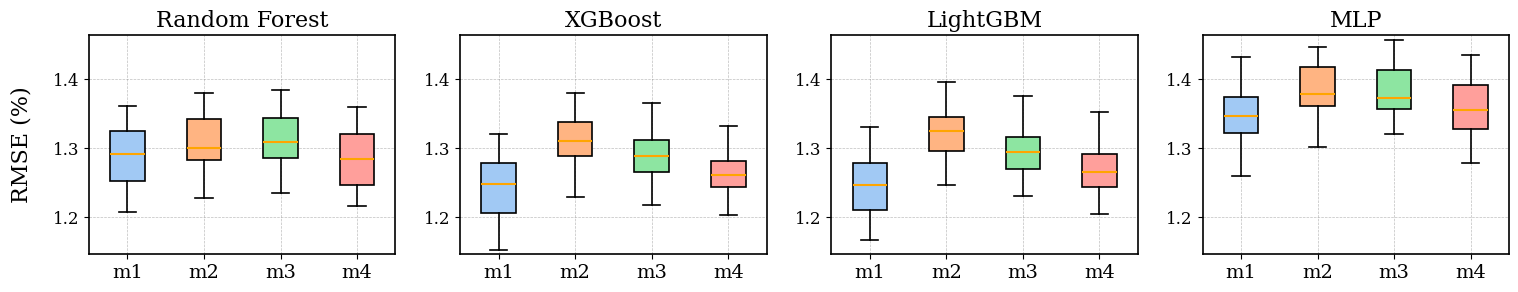

Saved: ./facet_boxplot_1row_RMSE.pdf


/tmp/ipython-input-4207565552.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[tag_map.get(t,t) for t in tag_list], showfliers=False, patch_artist=True)
/tmp/ipython-input-4207565552.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[tag_map.get(t,t) for t in tag_list], showfliers=False, patch_artist=True)
/tmp/ipython-input-4207565552.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[tag_map.get(t,t) for t in tag_list], showfliers=False, patch_artist=True)
/tmp/ipython-input-4207565552.py:191: MatplotlibDeprecationWa

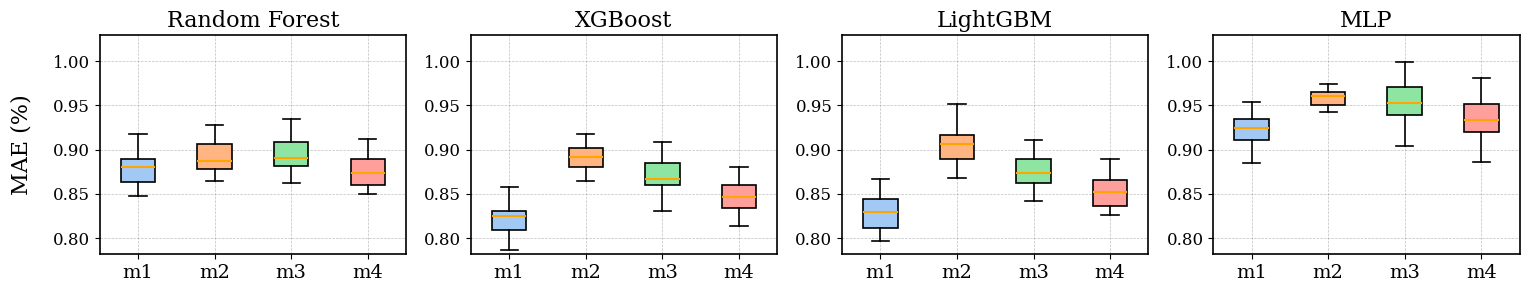

Saved: ./facet_boxplot_1row_MAE.pdf


In [37]:
# -*- coding: utf-8 -*-
# ==================== Config ====================
INPUT_PATH   = "Model_Results_BB_20_features.xlsx"
SAVE_DIR     = "."
BASE_HEIGHT  = 5.0

# >>> Filtros por MODELO (use os pretty names abaixo exatamente)
EXCLUDE_SUFFIXES  = {"ADA","Gradient Boosting"}   # aceita curto (RF, XGB...) ou nome completo
EXCLUDE_MODELS_EN = set()
INCLUDE_MODELS_EN = {"Random Forest", "XGBoost", "LightGBM", "MLP"}

# >>> Filtros por TAG de features (F1, F2, ...)
EXCLUDE_FEATURE_TAGS = {"F5", "F6", "F7", "F8"}  #
INCLUDE_FEATURE_TAGS = None


MODEL_ORDER   = ["Random Forest", "XGBoost", "LightGBM", "MLP"]
FEATURE_ORDER = ["F1", "F2", "F3", "F4"]

# ==================== Imports ====================
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# ==================== Estilo ====================
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42
plt.rcParams.update({
    "font.family": "serif",
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "axes.grid": True,
    "grid.color": "gray",
    "grid.alpha": 0.5,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "font.size": 12,
    "text.usetex": False
})

# ==================== Helpers ====================
def normalize_colname(s: str) -> str:
    s = str(s).strip()
    s = s.replace("R²", "R2").replace("R^2", "R2").replace("R_2", "R2")
    s = s.replace("-", "_").replace(" ", "_").replace(".", "_").replace("/", "_")
    s = re.sub(r"[()\[\]\{\}]", "", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def _as_feat_tag_from_prefix(prefix: str) -> str | None:
    m = re.match(r'(?i)^(features?|feat)(\d+)$', prefix)
    if m:
        return f"F{m.group(2)}"
    return None

MODEL_NAME_MAP = {
    "RF": "Random Forest",
    "DT": "Decision Tree",
    "ADA": "AdaBoost",
    "GB": "Gradient Boosting",
    "XGB": "XGBoost",
    "LGBM": "LightGBM",
    "NAIVE": "Naive",
    "MLP": "MLP",
}
MODEL_NAME_MAP.update({v.upper(): v for v in MODEL_NAME_MAP.values()})
YLABEL_BY_METRIC = {"RMSE": "RMSE (%)", "MAE": "MAE (%)", "R2": "R-squared"}
EXCLUDE_SUFFIXES_UP = {s.upper() for s in EXCLUDE_SUFFIXES}
col_pat_cache = {}

def parse_col(metric: str, col: str):
    key = (metric, col)
    if key in col_pat_cache:
        return col_pat_cache[key]
    s = str(col)
    # Formato A: METRIC_MODEL[_F#]
    if re.match(fr'(?i)^{metric}_', s):
        rest = re.sub(fr'(?i)^{metric}_', '', s)
        parts = rest.split('_')
        if len(parts) == 1:
            model_suffix = parts[0]
            feat_tag = None
        else:
            model_suffix = '_'.join(parts[:-1])
            last = parts[-1]
            feat_tag = last if re.match(r'(?i)^F\d+$', last) else None
            if feat_tag is None:
                model_suffix = rest
        col_pat_cache[key] = (model_suffix, feat_tag)
        return col_pat_cache[key]
    # Formato B: featureN_METRIC_MODEL
    m = re.match(fr'(?i)^(features?\d+)_({metric})_(.+)$', s)
    if m:
        feat_prefix = m.group(1)
        model_suffix = m.group(3)
        feat_tag = _as_feat_tag_from_prefix(feat_prefix)
        col_pat_cache[key] = (model_suffix, feat_tag)
        return col_pat_cache[key]
    col_pat_cache[key] = None
    return None

def pretty_model_name(model_suffix: str) -> str:
    return MODEL_NAME_MAP.get(model_suffix.upper(), model_suffix)

def label_with_tag(pretty_model: str, feat_tag: str | None) -> str:
    return f"{pretty_model}_{feat_tag}" if feat_tag else pretty_model

def split_label(label: str):
    m = re.match(r'^(.*?)(?:_(F\d+))?$', label)
    if m: return m.group(1), m.group(2)
    return label, None

def wide_for_metric(df_in: pd.DataFrame, metric: str) -> pd.DataFrame:
    cols_meta = []
    for c in df_in.columns:
        parsed = parse_col(metric, c)
        if parsed is None: continue
        model_suffix, feat_tag = parsed
        if model_suffix.upper() in EXCLUDE_SUFFIXES_UP: continue
        pretty = pretty_model_name(model_suffix)
        if EXCLUDE_MODELS_EN and pretty in EXCLUDE_MODELS_EN: continue
        if INCLUDE_MODELS_EN and pretty not in INCLUDE_MODELS_EN: continue
        if feat_tag and feat_tag in EXCLUDE_FEATURE_TAGS: continue
        cols_meta.append((c, model_suffix, feat_tag))
    if not cols_meta: return pd.DataFrame()
    sub = df_in[[c for (c, _, _) in cols_meta]].apply(pd.to_numeric, errors="coerce").copy()
    if metric.upper() == "R2": sub = sub.where(sub >= 0, np.nan)
    new_cols = [label_with_tag(pretty_model_name(m), t) for _, m, t in cols_meta]
    sub.columns = new_cols
    return sub.loc[:, sub.notna().any(axis=0)]

def order_with_reference(items, ref):
    out = [x for x in ref if x in items]
    out += [x for x in items if x not in out]
    return out

# ==================== Ler & preparar dados ====================
df = pd.read_excel(INPUT_PATH)
df = df.rename(columns={c: normalize_colname(c) for c in df.columns})

ALL_METRICS = ["RMSE", "MAE"]
metrics = [m for m in ALL_METRICS if any(df.columns.str.contains(fr'(?i)_{m}_'))]

# ==================== Plot ====================
for metric in metrics:
    sub = wide_for_metric(df, metric)
    if sub.empty:
        print(f"[WARN] Sem dados válidos para {metric}.")
        continue

    by_model = {}
    all_tags = set()
    for col in sub.columns:
        mdl, tag = split_label(col)
        tag = tag or "Only"
        vals = pd.to_numeric(sub[col], errors="coerce").dropna().values
        if vals.size == 0: continue
        by_model.setdefault(mdl, {})[tag] = vals
        all_tags.add(tag)

    if not by_model: continue

    models = order_with_reference(by_model.keys(), MODEL_ORDER)
    tags = order_with_reference(all_tags, FEATURE_ORDER)

    # Map F1-F4 -> m1-m4
    tag_map = {f"F{i}": f"m{i}" for i in range(1, 5)}
    tags_mapped = [tag_map.get(t, t) for t in tags]

    palette = sns.color_palette("pastel", len(tags_mapped))
    TAG_COLOR = {tags_mapped[i]: palette[i] for i in range(len(tags_mapped))}

    n_models = len(models)
    fig, axes = plt.subplots(nrows=1, ncols=n_models, figsize=(4.2*n_models, 4))
    if n_models == 1: axes = [axes]
    axes = axes.flatten()

    global_vals = np.concatenate([v for d in by_model.values() for v in d.values()])
    y_min, y_max = np.nanmin(global_vals), np.nanmax(global_vals)
    pad = 0.02 * (y_max - y_min)
    y_lim = (y_min - pad, y_max + pad)

    for ax, mdl in zip(axes, models):
        per_tag = by_model.get(mdl, {})
        tag_list = [t for t in tags if t in per_tag]
        if not tag_list: ax.axis("off"); continue
        data = [per_tag[t] for t in tag_list]
        bp = ax.boxplot(data, labels=[tag_map.get(t,t) for t in tag_list], showfliers=False, patch_artist=True)
        for patch, t in zip(bp['boxes'], [tag_map.get(t,t) for t in tag_list]):
            patch.set_facecolor(TAG_COLOR[t])
            patch.set_edgecolor("black")
            patch.set_linewidth(1.2)
        for whisker in bp['whiskers']: whisker.set(color="black", linewidth=1.2)
        for cap in bp['caps']: cap.set(color="black", linewidth=1.2)
        for median in bp['medians']: median.set(color="orange", linewidth=1.5)
        ax.set_title(mdl, fontsize=16)
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_ylim(*y_lim)
        plt.setp(ax.get_xticklabels(), rotation=0, ha='center', fontsize=14)

    axes[0].set_ylabel(YLABEL_BY_METRIC.get(metric, metric), fontsize=16, labelpad=15)
    for ax in axes[1:]: ax.set_ylabel("")

    if metric.upper() == "R2":
        for ax in axes: ax.set_ylim(0, max(1.05, y_lim[1]))

    # handles = [Patch(facecolor=TAG_COLOR[t], edgecolor="black", label=t) for t in tags_mapped]
    # fig.legend(handles=handles, title="Feature set", loc="lower center",
    #            bbox_to_anchor=(0.5, -0.02), ncol=len(tags_mapped), frameon=True)

    plt.tight_layout(rect=[0.06, 0.18, 0.98, 0.95])
    plt.show()

    os.makedirs(SAVE_DIR, exist_ok=True)
    out_pdf = os.path.join(SAVE_DIR, f"facet_boxplot_1row_{metric}.pdf")
    fig.savefig(out_pdf, format="pdf", bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {out_pdf}")
